In [1]:
!pip install transformers 
!pip install datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 116.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import nltk.corpus
nltk.download('treebank')
nltk.download('universal_tagset')
import numpy as np
import pandas as pd
from nltk.corpus import treebank
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset , DatasetDict
import torch
from torch import nn
from sklearn.metrics import classification_report , f1_score , accuracy_score
from transformers import AdamW
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt 

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [3]:
data = treebank.tagged_sents(tagset='universal')
X_data = []
Y_data = []
sents = []
for sent in data:
  xs = []
  ys = []
  for x in sent:
    if x[1] != "X" :
      xs.append(x[0])
      ys.append(x[1])
  X_data.append((xs," ".join(xs)))
  Y_data.append(ys)
  sents.append(" ".join(xs))
X_data_train , X_data_test , y_data_train , y_data_test = train_test_split(X_data,Y_data,test_size=0.2,random_state=20)

words = sorted(set([x for a in X_data_train for x in a[0]]))
tags = sorted(set([x for a in y_data_train for x in a]))

train_sentences=[]
for sent in range(len(X_data_train)):
    g=[]
    for i in range(len(X_data_train[sent][0])):
        g.append((X_data_train[sent][0][i],y_data_train[sent][i]))
    train_sentences.append(g)
    
test_sentences=[]
for sent in range(len(X_data_test)):
    g=[]
    for i in range(len(X_data_test[sent][0])):
        g.append((X_data_test[sent][0][i],y_data_test[sent][i]))
    test_sentences.append(g)
tag_to_index = dict(zip( tags, range(0,len(tags))))
word_to_index = dict(zip(words , range(0,len(words))))

In [4]:
print("number of training data :",len(X_data_train))
print("number of test data : ",len(X_data_test))
print("total number of data : " ,len(X_data))

number of training data : 3131
number of test data :  783
total number of data :  3914


In [5]:
print("mean of sentence lenght in training data :" , np.mean(list(map(len,[x[0] for x in X_data_train]))))
print("mean of sentence lenght in test data :" , np.mean(list(map(len,[x[0] for x in X_data_test]))))
print("mean of sentence lenght in whole of data :",np.mean(list(map(len,[x[0] for x in X_data]))))

mean of sentence lenght in training data : 24.047588629830724
mean of sentence lenght in test data : 23.97190293742018
mean of sentence lenght in whole of data : 24.032447623914155


In [6]:
print("max of sentence lenght in training data :" , np.max(list(map(len,[x[0] for x in X_data_train]))))
print("max of sentence lenght in test data :" , np.max(list(map(len,[x[0] for x in X_data_test]))))
print("max of sentence lenght in whole of data :",np.max(list(map(len,[x[0] for x in X_data]))))

max of sentence lenght in training data : 249
max of sentence lenght in test data : 81
max of sentence lenght in whole of data : 249


In [7]:
tags

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB']

In [8]:
train_data_dict = {"text_sents" : [x[1] for x in X_data_train],
                   "tag_sents" : train_sentences}
test_data_dict = {"text_sents" : [x[1] for x in X_data_test],
                  "tag_sents" : test_sentences}

In [9]:
train_dataset = Dataset.from_dict(train_data_dict)
test_dataset = Dataset.from_dict(test_data_dict)

In [10]:
train_dataset

Dataset({
    features: ['text_sents', 'tag_sents'],
    num_rows: 3131
})

In [11]:
def preprocess(record , tokenizer):
  encoded_inputs = tokenizer(
              record["text_sents"],
              truncation = True,
              max_length = len(tokenizer.tokenize(record["text_sents"]))+2 ,
              padding="max_length",
              return_overflowing_tokens = False,
              return_offsets_mapping = False)
  with torch.no_grad():
    out = model(input_ids = torch.Tensor(encoded_inputs["input_ids"]).unsqueeze(0).to(int).to(device)  , attention_mask = torch.Tensor(encoded_inputs["attention_mask"]).unsqueeze(0).to(int).to(device) , token_type_ids=torch.Tensor(encoded_inputs["token_type_ids"]).unsqueeze(0).to(int).to(device))
  vectors = torch.cat(out[2],0)
  
  word_vectors = []
  real = [x[0] for x in record["tag_sents"]]
  c = 0
  cc = 0
  t=[]
  s = []
  w_c = torch.zeros((13,768)).to(device)
  for i,token in enumerate( tokenizer.tokenize(record["text_sents"])):
    if token == real[c]:
      c += 1
      word_vectors.append(vectors[:,i+1].unsqueeze(0))
      s.append(token)
    else :
      w_c += vectors[:,i+1]
      t.append(token.replace("#",""))
      if "".join(t) == real[c]:
          c += 1
          s.append("".join(t))
          word_vectors.append(w_c.unsqueeze(0))
          t = []
          w_c = torch.zeros((13,768)).to(device)
          cc = 0
  labels = [tag_to_index[x[1]] for x in record["tag_sents"]]
  if len(word_vectors) != len(labels):
    print("error")
  return {"word_embeddings" : torch.cat(word_vectors,0) , "labels" : labels }

In [12]:
device="cuda"
c_model = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(c_model)
model = AutoModel.from_pretrained(c_model, output_hidden_states=True)
model.to(device)
model.eval();

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
train_dataset = train_dataset.map(lambda x : preprocess(x , tokenizer) , remove_columns = train_dataset.column_names)
test_dataset = test_dataset.map(lambda x : preprocess( x , tokenizer ) , remove_columns=test_dataset.column_names)

  0%|          | 0/3131 [00:00<?, ?ex/s]

  0%|          | 0/783 [00:00<?, ?ex/s]

In [14]:
train_dataset

Dataset({
    features: ['word_embeddings', 'labels'],
    num_rows: 3131
})

## SI probing


In [15]:
test_dataset.set_format(type='torch')
test_vectors = test_dataset[0]["word_embeddings"][:,11]
for i in tqdm_notebook(range(1,len(test_dataset))):
  test_vectors = torch.cat((test_vectors,test_dataset[i]["word_embeddings"][:,11]))

  0%|          | 0/782 [00:00<?, ?it/s]

In [16]:
train_dataset.set_format(type='torch')
train_vectors = train_dataset[0]["word_embeddings"][:,12]
for i in tqdm_notebook(range(1,len(train_dataset))):
  train_vectors = torch.cat((train_vectors , train_dataset[i]["word_embeddings"][:,12]))

  0%|          | 0/3130 [00:00<?, ?it/s]

In [17]:
train_labels = torch.cat(train_dataset["labels"],0)
test_lables = torch.cat(test_dataset["labels"],0)

In [18]:
print("shape of train vectors :" , train_vectors.shape)
print("shape of test vectors :" , test_vectors.shape)

shape of train vectors : torch.Size([75293, 768])
shape of test vectors : torch.Size([18770, 768])


In [19]:
#normalization
train_vectors_norm = (train_vectors - torch.min(train_vectors,0)[0]) / (torch.max(train_vectors,0)[0] - torch.min(train_vectors,0)[0])
test_vectors_norm = (test_vectors - torch.min(train_vectors,0)[0]) / (torch.max(train_vectors,0)[0] - torch.min(train_vectors,0)[0])

In [21]:
import numpy as np
def get_cross_SI(train_data,test_data,train_labels,test_labels):
  idxs = []
  test_bucket = 10000
  train_bucket = 20000
  for i in range(0,int(np.ceil(len(test_data)/test_bucket))):
    min_values_totals = []
    indicex_totals = []
    labels = []
    for j in range(0,int(np.ceil(len(train_data)/train_bucket))):
      distance = torch.cdist(test_data[i*test_bucket:(i+1)*test_bucket,:].to("cuda") , train_data[j*train_bucket:(j+1)*train_bucket,:].to("cuda"))
      distance[distance<0.1] = torch.inf
      min_values , indices = torch.min(distance,1)
      indices += (j) * train_bucket
      min_values_totals.append(min_values.unsqueeze(0))
      indicex_totals.append(indices.unsqueeze(0))
    a = torch.cat(min_values_totals).T
    indicex_totals = torch.cat(indicex_totals).T
    true_min_values_bucket = torch.argmin(a , dim=1 )

    for index , k in enumerate(true_min_values_bucket):
      idxs.append(indicex_totals[index][k])
   

  return torch.sum(train_labels[idxs] == test_labels).item() 

In [22]:
k = 10
SI_scores = []
cross_SI_scores = []
best_feature_set = []
for fk in range(1,k):
  
  scores = []
  for i in tqdm_notebook(range(len(train_vectors_norm[0]))):
    if i not in best_feature_set:
      train_vec = train_vectors_norm[:,torch.Tensor(best_feature_set + [i]).to(torch.long)]
      test_vec = test_vectors_norm[:,torch.Tensor(best_feature_set + [i]).to(torch.long)]
      score = get_cross_SI(train_vec,test_vec,train_labels,test_lables)
      scores.append(score)
    else:
      scores.append(-1)
  index_best_new_feture = torch.argmax(torch.Tensor(scores))
  print(index_best_new_feture)
  print("accuracy on training data is : " ,scores[index_best_new_feture]/len(train_vectors_norm))
  acc_cross = get_cross_SI(train_vectors_norm[:,torch.Tensor(best_feature_set).to(torch.long)],test_vectors_norm[:,torch.Tensor(best_feature_set).to(torch.long)],train_labels,test_lables)/len(test_lables)
  SI_scores.append(scores[index_best_new_feture]/len(train_vectors_norm))
  cross_SI_scores.append(acc_cross)
  print("accuracy on test data (based on cross SI)" , acc_cross)
  best_feature_set = best_feature_set + [index_best_new_feture.tolist()]

  0%|          | 0/768 [00:00<?, ?it/s]

tensor(304)
accuracy on training data is :  0.04596708857397102
accuracy on test data (based on cross SI) 0.035748534896110816


  0%|          | 0/768 [00:00<?, ?it/s]

tensor(557)
accuracy on training data is :  0.04694991566281062
accuracy on test data (based on cross SI) 0.18438998401704848


  0%|          | 0/768 [00:00<?, ?it/s]

tensor(370)
accuracy on training data is :  0.06027120715073114
accuracy on test data (based on cross SI) 0.1883324453915823


  0%|          | 0/768 [00:00<?, ?it/s]

tensor(545)
accuracy on training data is :  0.06915649529172699
accuracy on test data (based on cross SI) 0.2417687799680341


  0%|          | 0/768 [00:00<?, ?it/s]

tensor(296)
accuracy on training data is :  0.0744159483617335
accuracy on test data (based on cross SI) 0.27741076185402236


  0%|          | 0/768 [00:00<?, ?it/s]

tensor(580)
accuracy on training data is :  0.07943633538310334
accuracy on test data (based on cross SI) 0.2985082578582845


  0%|          | 0/768 [00:00<?, ?it/s]

tensor(252)
accuracy on training data is :  0.08423093780298302
accuracy on test data (based on cross SI) 0.3186467767714438


  0%|          | 0/768 [00:00<?, ?it/s]

tensor(511)
accuracy on training data is :  0.08796302445114419
accuracy on test data (based on cross SI) 0.3378795950985615


  0%|          | 0/768 [00:00<?, ?it/s]

tensor(490)
accuracy on training data is :  0.09087166137622356
accuracy on test data (based on cross SI) 0.35285029302077786


In [29]:
# SI_scores =  SI_scores[:9]
# cross_SI_scores =  cross_SI_scores[:9]
# best_feature_set = best_feature_set[:9]

In [ ]:
k = 10
for fk in range(1,k):
  
  scores = []
  for i in tqdm_notebook(range(len(train_vectors_norm[0]))):
    if i not in best_feature_set:
      train_vec = train_vectors_norm[:,torch.Tensor(best_feature_set + [i]).to(torch.long)]
      test_vec = test_vectors_norm[:,torch.Tensor(best_feature_set + [i]).to(torch.long)]
      score = get_cross_SI(train_vec,test_vec,train_labels,test_lables)
      scores.append(score)
    else:
      scores.append(-1)
  index_best_new_feture = torch.argmax(torch.Tensor(scores))
  print(index_best_new_feture)
  print("accuracy on training data is : " ,scores[index_best_new_feture]/len(train_vectors_norm))
  acc_cross = get_cross_SI(train_vectors_norm[:,torch.Tensor(best_feature_set).to(torch.long)],test_vectors_norm[:,torch.Tensor(best_feature_set).to(torch.long)],train_labels,test_lables)/len(test_lables)
  SI_scores.append(scores[index_best_new_feture]/len(train_vectors_norm))
  cross_SI_scores.append( acc_cross )
  print("accuracy on test data (based on cross SI)" , acc_cross )
  best_feature_set = best_feature_set + [index_best_new_feture.tolist()]

  0%|          | 0/768 [00:00<?, ?it/s]

tensor(39)
accuracy on training data is :  0.0925982495052661
accuracy on test data (based on cross SI) 0.36451784762919553


  0%|          | 0/768 [00:00<?, ?it/s]

#edge probing

In [ ]:
def plot(train_hist,test_hist,lbl="acc"):
  plt.plot([i for i in range(len(train_hist))], train_hist, label = "train_"+lbl)
  plt.plot([i for i in range(len(test_hist))], test_hist, label = "test_"+lbl)
  plt.xlabel('epochs') 
  plt.ylabel(lbl) 
  plt.legend()
  plt.show()

In [ ]:
class Edge_probing(nn.Module):
  def __init__(self):
     super(Edge_probing, self).__init__()
     self.fc = nn.Linear(768 , len(tags))
  
  def forward(self,x):
    return self.fc(x)

In [ ]:
def train(model , optimizer , loss_fn , train_dataset  ,validation_dataset , lay ,batch_size = 4,epochs = 30, device = "cuda"):
  model.to(device)
  best_loss = 100
  best_score = 0
  best_epoch = 0
  acc_train = []
  acc_test = []
  loss_train = []
  loss_test = []
  for epoch in range(epochs):
    training_loss = 0.0
    val_loss =0.0
    model.train()
    
    t_labels = []
    t_preds = []
    for i in tqdm_notebook(np.arange(0,len(train_dataset),batch_size)):
      embeddings = torch.cat(train_dataset[i:i+4]["word_embeddings"],0)[:,lay].to(device)
      labels = torch.cat(train_dataset[i:i+batch_size]["labels"],0).to(torch.long)
      preds = model(embeddings)
      t_labels += labels.numpy().tolist()
      
      optimizer.zero_grad()
      preds = model(embeddings)
      loss = loss_fn(preds , labels.to(device))
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
      t_preds +=  preds.argmax(axis=1).cpu().numpy().tolist()

    training_loss = training_loss / len(train_dataset)

    train_accuracy =  accuracy_score(t_labels, t_preds, normalize=True)

    valid_loss , valid_acc , valid_f1_wieghted = validation(model , validation_dataset , loss_fn  ,lay, False, device )

   
      

    loss_train.append(training_loss)
    loss_test.append(valid_loss)
    acc_train.append(train_accuracy)
    acc_test.append(valid_acc)
    print('Epoch: {},training loss: {:.2f} , train accuracy: {:.2f} ,validation loss :{:.2f} , validation acc:{:.2f}'.format(epoch , training_loss ,train_accuracy,valid_loss,valid_acc))
  
  plot(acc_train,acc_test,"acc")
  plot(loss_train,loss_test,"loss")



In [ ]:
def validation( model , val_dataset , loss_fn , lay, test = True , device = "cuda"  ):
  val_loss = 0.0
  model.eval()
  num_words = 0
  tps = 0
  reals = []
  preds_list = []
  for i in np.arange(0,len(val_dataset),4):
      embeddings = torch.cat(val_dataset[i:i+4]["word_embeddings"],0)[:,lay].to(device)
      labels = torch.cat(val_dataset[i:i+4]["labels"],0).to(torch.long)
      preds = model(embeddings)
      loss = loss_fn(preds , labels.to(device))
      val_loss += loss.item()
      reals += labels.numpy().tolist()
      preds_list += preds.argmax(axis=1).cpu().numpy().tolist()

  val_loss = val_loss / len(val_dataset)
  accuracy = accuracy_score(reals, preds_list, normalize=True)
  val_f1_wighted = f1_score(reals, preds_list, average='macro')
  if test:
    print(classification_report(reals , preds_list ))
  return val_loss ,accuracy,val_f1_wighted

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/783 [00:00<?, ?it/s]

Epoch: 0,training loss: 0.42 , train accuracy: 0.54 ,validation loss :0.29 , validation acc:0.78


  0%|          | 0/783 [00:00<?, ?it/s]

Epoch: 1,training loss: 0.22 , train accuracy: 0.85 ,validation loss :0.17 , validation acc:0.89


  0%|          | 0/783 [00:00<?, ?it/s]

Epoch: 2,training loss: 0.14 , train accuracy: 0.91 ,validation loss :0.12 , validation acc:0.91


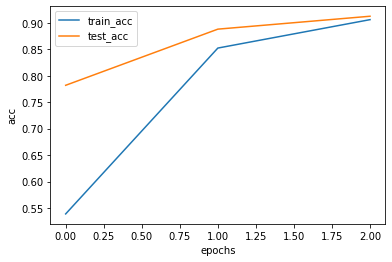

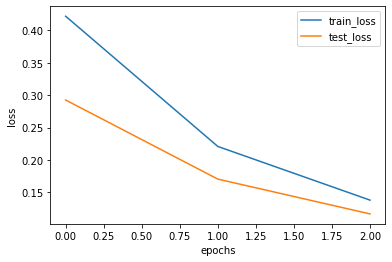

In [ ]:
batch_size = 10
lay = 1
train_dataset.set_format(type="torch")
test_dataset.set_format(type='torch')
loss_fn = nn.CrossEntropyLoss()
edge_model = Edge_probing()
optimizer = AdamW(edge_model.parameters(), lr=2e-5) 
train(edge_model , optimizer , loss_fn , train_dataset  ,test_dataset , lay ,epochs = 3, device = "cuda")

In [ ]:
for i in np.arange(0,len(test_dataset),4):
  print(torch.cat(test_dataset[i:i+4]["word_embeddings"],0)[:,6].shape)
  print(torch.cat(test_dataset[i:i+4]["labels"],0).shape)
  barak

torch.Size([81, 768])
torch.Size([81])


NameError: ignored

In [ ]:
test_dataset[0:4]

TypeError: ignored

In [ ]:
test_vectors = test_dataset[0]["word_embeddings"][:,12]

In [ ]:
t_lables = torch.cat(test_dataset["labels"],0)

In [ ]:
for i in tqdm_notebook(range(1,len(test_dataset))):
  test_vectors = torch.cat((test_vectors,test_dataset[i]["word_embeddings"][:,12]))

  0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
test_vectors.to(device).shape

torch.Size([18770, 768])

In [ ]:
test_vectors_norm = (test_vectors - torch.min(test_vectors,0)[0]) / (torch.max(test_vectors,0)[0] - torch.min(test_vectors,0)[0])

In [ ]:
test_vectors_norm

torch.Size([18770, 768])

tensor([6, 6, 6,  ..., 1, 6, 0])

In [ ]:
test_dataset.set_format(type='torch')
test_vectors = test_dataset[0]["word_embeddings"][:,12]
for i in tqdm_notebook(range(1,len(test_dataset))):
  test_vectors = torch.cat((test_vectors,test_dataset[i]["word_embeddings"][:,12]))

  0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
train_dataset.set_format(type='torch')
train_vectors = train_dataset[0]["word_embeddings"][:,12]
for i in tqdm_notebook(range(1,len(train_dataset))):
  train_vectors = torch.cat((train_vectors , train_dataset[i]["word_embeddings"][:,12]))

  0%|          | 0/3130 [00:00<?, ?it/s]

In [ ]:
train_labels = torch.cat(train_dataset["labels"],0)
test_lables = torch.cat(test_dataset["labels"],0)


In [ ]:
print("shape of train vectors :" , train_vectors.shape)
print("shape of test vectors :" , test_vectors.shape)


shape of train vectors : torch.Size([75293, 768])
shape of test vectors : torch.Size([18770, 768])


In [ ]:
#normalization
train_vectors_norm = (train_vectors - torch.min(train_vectors,0)[0]) / (torch.max(train_vectors,0)[0] - torch.min(train_vectors,0)[0])
test_vectors_norm = (test_vectors - torch.min(test_vectors,0)[0]) / (torch.max(test_vectors,0)[0] - torch.min(test_vectors,0)[0])

In [ ]:
import time
def time_execution(func):
  def wrapper(*args , **kargs):
    t1 = time.perf_counter()
    res = func(*args,**kargs)
    t2 = time.perf_counter()
    print(f"exexution time is {t2-t1}")
    return res
  return wrapper

In [ ]:
# time_execution
def get_cross_SI(train_data,test_data,train_labels,test_labels):
  idxs = []
  test_bucket = 10000
  train_bucket = 20000
  for i in range(int(np.ceil(len(test_data)/test_bucket))):
    min_values_totals = []
    indicex_totals = []
    labels = []
    for j in range(int(np.ceil(len(train_data)/train_bucket))):
      distance = torch.cdist(test_data[i*test_bucket:(i+1)*test_bucket,:].to("cuda") , train_data[j*train_bucket:(j+1)*train_bucket,:].to("cuda")).fill_diagonal_(torch.inf)
      # print(distance.shape)
      min_values , indices = torch.min(distance,1)
      indices += (j) * train_bucket
      min_values_totals.append(min_values.unsqueeze(0))
      indicex_totals.append(indices.unsqueeze(0))
      # print(min_values.shape)
    a = torch.cat(min_values_totals)
    indicex_totals = torch.cat(indicex_totals)
    # print(a.shape,"---")
    true_min_values_bucket = torch.argmin(a , dim=0 )
    for index , k in enumerate(true_min_values_bucket):
      idxs.append(indicex_totals[k][index])
  return torch.sum(train_labels[idxs] == test_labels).item()

In [ ]:
k = 3
best_feature_set = []
for fk in range(1,k):
  
  scores = []
  for i in tqdm_notebook(range(len(train_vectors_norm[0]))):
    if i not in best_feature_set:
      t = train_vectors_norm[:,torch.Tensor(best_feature_set + [i]).to(torch.long)]
      score = get_cross_SI(t,t,train_labels,train_labels)
      scores.append(score)
  index_best_new_feture = torch.argmax(torch.Tensor(scores))
  print(index_best_new_feture)
  print(scores[index_best_new_feture]/len(train_vectors_norm))
  best_feature_set = best_feature_set + [index_best_new_feture.tolist()]

  0%|          | 0/768 [00:00<?, ?it/s]

tensor(557)
0.2470349169245481


  0%|          | 0/768 [00:00<?, ?it/s]

tensor(188)
0.4508387233873003


In [ ]:
best_feature_set

[557, 188]

In [ ]:
get_cross_SI(train_vectors_norm[:,torch.Tensor(best_feature_set).to(torch.long)],test_vectors_norm[:,torch.Tensor(best_feature_set).to(torch.long)],train_labels,test_lables)/len(test_lables)

0.24965370271710177

In [ ]:
best_feature_set

[557, 188, 271, 251]

In [ ]:
D = get_distance_Matrix(train_vectors_norm[:,torch.Tensor(best_feature_set[:20] ).to(torch.long)],train_vectors_norm[:,torch.Tensor(best_feature_set[:20] ).to(torch.long)] )
score / len(vectors)

In [ ]:
k = 4
best_feature_set = [557,188]
for fk in range(1,k):
  
  scores = []
  for i in tqdm_notebook(range(len(train_vectors_norm[0]))):
    if i not in best_feature_set:
      t = train_vectors_norm[:,torch.Tensor(best_feature_set + [i]).to(torch.long)]
      score = get_cross_SI(t,t,train_labels,train_labels)
      scores.append(score)
  index_best_new_feture = torch.argmax(torch.Tensor(scores))
  print(index_best_new_feture)
  print(scores[index_best_new_feture]/len(train_vectors_norm))
  best_feature_set = best_feature_set + [index_best_new_feture.tolist()]

  0%|          | 0/768 [00:00<?, ?it/s]

tensor(271)
0.6393688656315992


  0%|          | 0/768 [00:00<?, ?it/s]

## Cross SI

In [ ]:
torch.cdist(vectors.to(device),vectors.to(device))

In [ ]:
torch.min(torch.Tensor([[1,20,3,4],[5,6,7,8]]),0)[0]

tensor([1., 6., 3., 4.])

In [ ]:
test_vectors.shape

torch.Size([29, 768])

In [ ]:
test_cat.shape

In [ ]:
test_dataset.set_format(type='torch')
test_dataset[0:3]

In [ ]:
np.arange(0,len(test_dataset),4)

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152,
       156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204,
       208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256,
       260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308,
       312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360,
       364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412,
       416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464,
       468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516,
       520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568,
       572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620,
       624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672,
       676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 72

In [ ]:
test_vectors_norm.shape

torch.Size([18770, 768])

# Sepration Index

In [ ]:
def get_distance_Matrix(vectors):
  # X = vectors.clone()
  # M = torch.matmul(X,X.T).to(device)
  # d = torch.diag(M)
  # W = torch.cat([d.unsqueeze(0) for i in range(len(vectors))],0).to(device)
  # W = torch.Tensor(W).to(device)
  # D = W + W.T - (2*M)
  # D.fill_diagonal_(torch.inf)
  # return D
  return torch.cdist(vectors.to(device),vectors.to(device)).fill_diagonal_(torch.inf)

In [ ]:
def get_SI_score(vectors , labels):
  D = get_distance_Matrix(vectors)
  idxs =torch.argmin(D,0)
  score = torch.sum(labels[idxs] == labels) 
  return score

In [ ]:
D = get_distance_Matrix(test_vectors_norm[:5000])

In [ ]:
k = 40
best_feature_set = []
for fk in range(1,k):
  
  scores = []
  for i in tqdm_notebook(range(len(test_vectors_norm[0]))):
    D = get_distance_Matrix(test_vectors_norm[:,torch.Tensor(best_feature_set + [i]).to(torch.long)] )
    idxs = torch.argmin(D,0)
    score = torch.sum(t_lables[idxs.cpu()] == t_lables)
    scores.append(score)
  index_best_new_feture = torch.argmax(torch.Tensor(scores))
  best_feature_set = best_feature_set + [index_best_new_feture.tolist()]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

In [ ]:
best_feature_set

[557,
 252,
 272,
 605,
 563,
 382,
 595,
 407,
 639,
 319,
 609,
 338,
 390,
 764,
 66,
 604,
 236,
 254,
 53]

In [ ]:
best_feature_set

[557, 252, 403, 76]

In [ ]:
vectors = test_vectors_norm
labels = t_lables

In [ ]:
D = get_distance_Matrix(vectors[:,torch.Tensor(best_feature_set[:20] ).to(torch.long)] )
idxs = torch.argmin(D,0)
score = torch.sum(labels[idxs.cpu()] == labels) 
score / len(vectors)

tensor(0.7343)

In [ ]:
idxs

tensor([3487,  693,  245,  ..., 2104,   51, 1850])

torch.Size([5000, 5000])


tensor([[    inf,  2.7780,  6.7556,  ..., 16.6733,  5.2581,  5.1160],
        [ 2.7780,     inf,  3.8662,  ..., 16.0035,  3.5711,  3.7234],
        [ 6.7556,  3.8662,     inf,  ..., 17.7499,  7.1786,  7.2812],
        ...,
        [16.6733, 16.0035, 17.7499,  ...,     inf, 14.6316, 15.8430],
        [ 5.2581,  3.5711,  7.1786,  ..., 14.6316,     inf,  3.0746],
        [ 5.1160,  3.7234,  7.2812,  ..., 15.8430,  3.0746,     inf]],
       device='cuda:0')

In [ ]:
[d for i in range(len(test_vectors_norm[:5000]))]

[tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),
 tensor([207.3902, 207.1514, 204.4609,  ..., 212.9548, 206.7824, 207.7289]),

In [ ]:
!nvidia-smi

Wed Dec 28 07:38:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    27W /  70W |   2606MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------